# Generating dataset

In [1]:
import sys
sys.path.append('../simulator')

from AgentBasedModel import *
from AgentBasedModel.extra import *
import AgentBasedModel.settings as settings
from AgentBasedModel.visualization import (
    plot_price,
    plot_price_fundamental,
    plot_liquidity,
    plot_orderbook_imbalance,
    plot_trade_imbalance,
    plot_spread,
    plot_gain
)
from random import randint
from pathlib import Path

import random

datasets_quantity = 1

stocks_quantity = 10

simulator_iterations = 1000

risk_free_rate = 5e-4
        
price = 100
        
dividend = price * risk_free_rate


assets = [
    Stock(dividend) for _ in range(stocks_quantity)
]

    # Exchange agent (intermediary between market and customer)
exchanges = [
    ExchangeAgent(assets[i], risk_free_rate) for i in range(stocks_quantity) #for x in range(10)   # single asset
]

    # Market customers
traders = [
    *[Random(exchanges[randint(0, stocks_quantity - 1)])         for _ in range(500)],
    *[Fundamentalist(exchanges[randint(0, stocks_quantity - 1)]) for _ in range(500)],
    *[Chartist2D(exchanges)                                      for _ in range(200)],
    *[MarketMaker2D(exchanges)                                   for _ in range(50)]
]

    # Run simulation
simulator = Simulator(**{
    'assets': assets,
    'exchanges': exchanges,
    'traders': traders,
    #'events': [MarketPriceShock(0, 200, -10)]
})


def simulate() -> SimulatorInfo:
    # Initialization of stocks

    info = simulator.info

    simulator.simulate(simulator_iterations, silent=False)

    return info
      

# Saving metrics
def collect_save_dataset(info: SimulatorInfo, iteration: int):

    metrics = {
        "gain": lambda:plot_gain(info, left_iter=1, right_iter=simulator_iterations, show = False),
        "spread":lambda:plot_spread(info, left_iter=1, right_iter=simulator_iterations, show = False),
        "obi":lambda:plot_orderbook_imbalance(info, show=False),
        "timb":lambda:plot_trade_imbalance(info, left_iter=1, right_iter=simulator_iterations, show = False),
        "price":lambda:plot_price(info, show = False, spread=False)
    }

    for metric, func in metrics.items():
        dataset = func()
        dataset.to_csv(f'../dataset/{metric}_{iteration}.csv')               
            

In [2]:
info = simulate()

Simulation: 100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


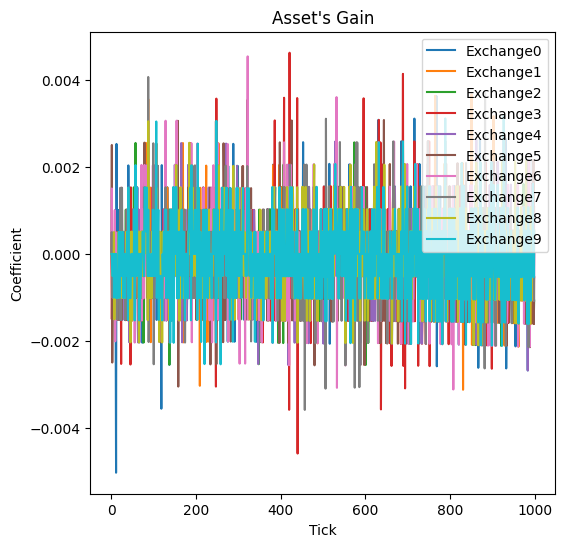

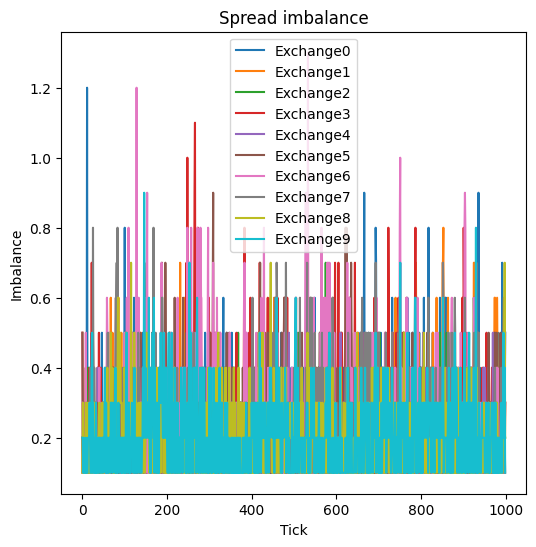

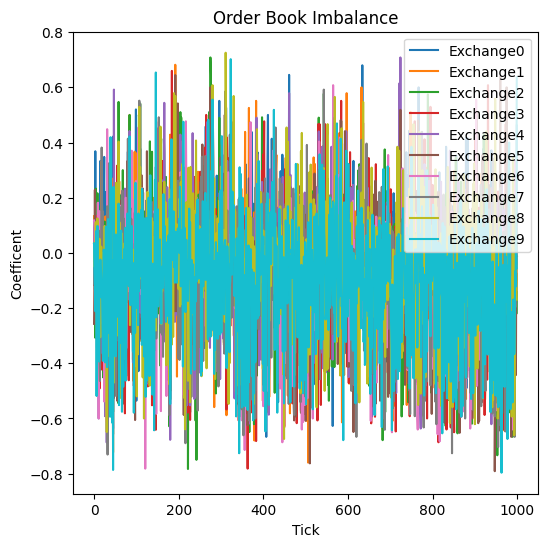

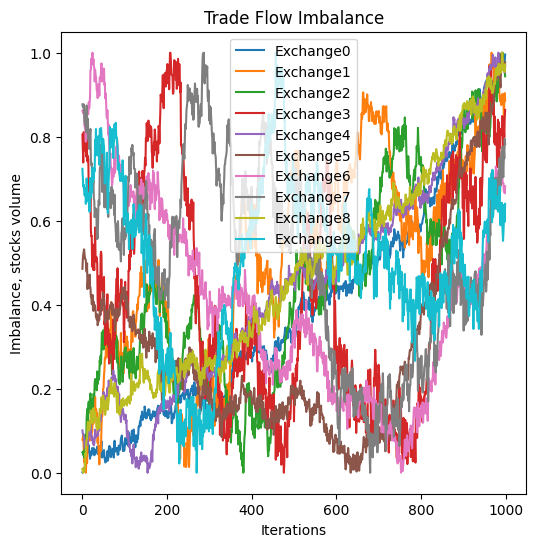

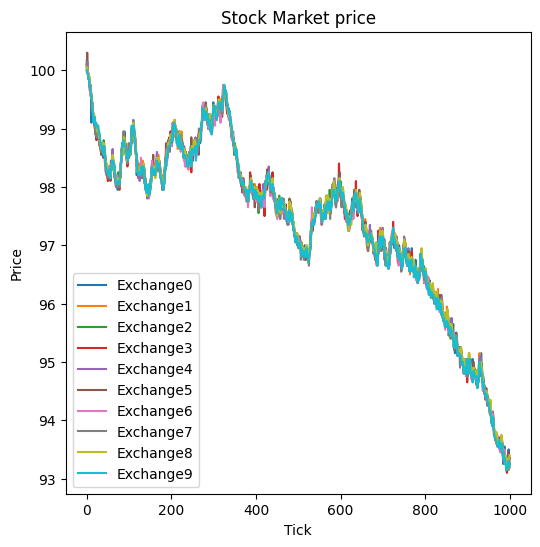

In [3]:
collect_save_dataset(info,iteration=0)

# Data processing

In [4]:
import os
import pandas as pd
import numpy as np
import sklearn
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

In [5]:
# reading files

def get_metrics():
    directory = '../dataset'

    files = [file for file in os.listdir(directory) if file.endswith('.csv')]

    dfs = {}

    for file in files:
        file_path = os.path.join(directory,file)
        df = pd.read_csv(file_path)
        df.drop(df.columns[0],inplace = True,axis = 1)
        dfs[file] = df
    
    return dfs

In [6]:
dfs = get_metrics()

In [7]:
dfs['gain_0.csv'].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')

In [8]:
# target
y = dfs['price_0.csv']['0']

dfs.pop('price_0.csv')

array_X = []

for i in range(stocks_quantity):
    array_X.append(pd.concat([value.iloc[:,:i+1] for key, value in dfs.items()],axis = 1))


In [9]:
array_X[3]

,0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3
0,0.000000,0.000000,0.000000,0.000000,0.111111,0.133333,0.032258,-0.032258,0.2,0.1,0.2,0.5,81.0,-83.0,25.0,133.0
1,0.000500,0.000500,0.000000,-0.001498,0.068493,0.000000,0.022727,-0.117647,0.1,0.2,0.2,0.2,72.0,-71.0,30.0,64.0
2,-0.001498,-0.001499,0.000000,-0.000500,0.000000,0.000000,0.010526,0.033708,0.2,0.1,0.2,0.1,78.0,-47.0,6.0,-1.0
3,-0.000500,0.000000,-0.000500,0.000000,0.368421,-0.063830,-0.307692,-0.032258,0.3,0.3,0.1,0.3,114.0,-136.0,28.0,146.0
4,-0.000500,-0.001001,-0.000500,-0.000500,0.000000,0.086420,0.233333,0.135135,0.2,0.3,0.2,0.2,105.0,-233.0,32.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000536,0.000537,0.000537,-0.000536,0.304348,0.036145,-0.232877,-0.072464,0.3,0.4,0.2,0.4,7330.0,2201.0,2876.0,145.0
996,0.002145,0.001073,0.000536,0.000536,-0.033333,-0.377049,0.012658,-0.037037,0.3,0.6,0.1,0.5,7257.0,2026.0,2855.0,157.0
997,0.000535,0.000000,0.002145,0.002145,-0.076923,-0.265306,-0.048780,-0.028571,0.2,0.6,0.1,0.3,7276.0,2185.0,2804.0,122.0
998,-0.001604,-0.001608,-0.001605,-0.001605,0.088608,0.060241,-0.220779,-0.042254,0.3,0.1,0.2,0.2,7383.0,2233.0,2799.0,214.0


In [12]:
models = {
    'Linear Regression': (LinearRegression(), {'fit_intercept': [True, False]}),
    #'Random Forest': (RandomForestRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    #'XGBoost': (XGBRegressor(), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    #'Gradient Boosting': (GradientBoostingRegressor(silent = True), {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}),
    #'CatBoost': (CatBoostRegressor(), {'iterations': [50, 100, 200], 'depth': [5, 10, 15]}),
}


rsquared_results = []

for i, X in enumerate(array_X):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

    results = {}

    # Iterate over each model and perform GridSearchCV
    for model_name, (model, params) in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(model, params, scoring='r2', cv=2)
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator from GridSearchCV
        best_model = grid_search.best_estimator_
        
        # Evaluate the model on the test set
        y_pred = best_model.predict(X_test)
        rsquared_ = r2_score(y_test, y_pred)
        
        # Store the results in the dictionary
        results[model_name] = {'best_model': best_model, 'rsquared': rsquared_}

    # Print the results
    for model_name, result in results.items():
        print(f"{model_name} using first {i} features: R^2 = {result['rsquared']}")

    rsquared_results.append(results)


# You can access the best model for each algorithm as follows:
# best_linear_regression_model = results['Linear Regression']['best_model']
# best_random_forest_model = results['Random Forest']['best_model']
# best_xgboost_model = results['XGBoost']['best_model']
# best_gradient_boosting_model = results['Gradient Boosting']['best_model']
# best_catboost_model = results['CatBoost']['best_model']


Training Linear Regression...
Linear Regression using first 0 features: R^2 = 0.8906153861752812
Training Linear Regression...
Linear Regression using first 1 features: R^2 = 0.8966005737166405
Training Linear Regression...
Linear Regression using first 2 features: R^2 = 0.9000937932115135
Training Linear Regression...
Linear Regression using first 3 features: R^2 = 0.9152306880915752
Training Linear Regression...
Linear Regression using first 4 features: R^2 = 0.9213205824246409
Training Linear Regression...
Linear Regression using first 5 features: R^2 = 0.9680088652097982
Training Linear Regression...
Linear Regression using first 6 features: R^2 = 0.9690149892386523
Training Linear Regression...
Linear Regression using first 7 features: R^2 = 0.9683743628747852
Training Linear Regression...
Linear Regression using first 8 features: R^2 = 0.9734404097778849
Training Linear Regression...
Linear Regression using first 9 features: R^2 = 0.9777981035028173


In [12]:
y = dfs['price_0.csv']

dfs.pop('price_0.csv')

X = pd.concat([value for key, value in dfs.items()], axis = 1)

In [9]:
X_one = X.drop(['1'],axis=1)

In [10]:
y_one = y.drop(['1'],axis=1)

In [11]:
X_one_train, X_one_test, y_one_train, y_one_test = train_test_split(X_one, y_one, test_size=0.25)

## Without cross-impact

In [12]:
X_one_train.columns, y_one_train.columns

(Index(['0', '0', '0', '0'], dtype='object'), Index(['0'], dtype='object'))

In [13]:
model = LinearRegression()

model.fit(X_one_train, y_one_train)

predicts = model.predict(X_one_test)

r2_score(y_one_test, predicts)

0.3246098996408371

## Using cross-impact of second stock's metrics

In [14]:
y_common = y.drop(['1'],axis = 1)

In [15]:
X.columns, y_common.columns

(Index(['0', '1', '0', '1', '0', '1', '0', '1'], dtype='object'),
 Index(['0'], dtype='object'))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_common, test_size=0.25)

model.fit(X_train, y_train)

predicts_ci = model.predict(X_test)

r2_score(y_test, predicts_ci)

0.4191991757952749

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
linear_model = LinearRegression()

linear_model.fit(X_train,y_train)

LinearRegression()

In [19]:
y_pred = linear_model.predict(X_test)

In [20]:
mae_test = mean_absolute_error(y_test,y_pred)

NameError: name 'mean_absolute_error' is not defined

In [ ]:
rsquared_test = r2_score(y_pred, y_test)
rsquared_test

-0.6642877768836816